In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
import xgboost

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
generos_todo = pd.read_csv('../data/generos_todo.csv')
generos_resumido = pd.read_csv('../data/generos_resumido.csv')
generos_muy_resumido = pd.read_csv('../data/generos_muy_resumido.csv')
generos_sin_mezclas = pd.read_csv('../data/generos_sin_mezclas.csv')
generos_buenos = pd.read_csv('../data/generos_buenos.csv')
generos_malos = pd.read_csv('../data/generos_malos.csv')

Ahora que tenemos nuestras columnas listas, podemos empezar a probar modelos. Al tratarse de un problema de clasificación de canciones en cuanto a su género, tendremos que usar modelos de clasificación como la regresión logística, el decision tree / random forest, etc. Primero probaremos con nuestro dataset completo. Es decir, incluyendo todas las columnas que nos hemos quedado después de hacer la limpieza:

DATASET CON TODAS LAS VARIABLES:

In [52]:
# Separamos las que serán nuestras features en el modelo y la variable independiente que queremos predecir, en este caso el género de la canción
X = generos_todo.drop(columns={'genero'})
Y = generos_todo['genero']

In [53]:
# Separamos en train y test para poder comprobar la eficacia del modelo. Reservamos el 20% del dato para el conjunto de test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [54]:
# Comprobamos el tamaño de cada conjunto
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('Y_train shape: ', Y_train.shape)
print('Y_test shape: ', Y_test.shape)

X_train shape:  (15526, 12)
X_test shape:  (3882, 12)
Y_train shape:  (15526,)
Y_test shape:  (3882,)


### MODELO DE REGRESIÓN LOGÍSTICA

Algunas variables de nuestro dataset están en escalas diferentes. 7 de ellas están normalizadas de 0 a 1, pero otras no lo están. Un modelo de regresión logística necesita que sus variables estén escaladas para funcionar correctamente. La regresión logística usa el descenso de gradiente para minimizar el error. Nuestro algoritmo trabajará iterativamente actualizando los parámetros en pequeños "pasos", dirigiéndolos hasta llegar a la convergencia. En algunos casos puede que nuestro modelo no converja a menos que las variables estén escaladas así que este paso será muy recomendable antes de entrenar el modelo. Las variables que nos faltan por escalar son volumen, popularidad, clave y tempo. Otros modelos como random forest o gradient boosting no requieren de escalado de las variables.

In [55]:
escalador = StandardScaler()
escalador.fit(X_train, Y_train)
X_train_scal = escalador.transform(X_train)
X_test_scal = escalador.transform(X_test)

In [56]:
reg_log = LogisticRegression()

reg_log_param = {
    "penalty": ['l1', 'l2'],
    "C": [0.001, 0.01, 0.1, 1, 10],
    'solver' : ['saga', 'liblinear'],
    'max_iter' : [1000]
}

gs_reg_log = GridSearchCV(estimator=reg_log,
                         param_grid=reg_log_param,
                         cv = 2,
                         scoring = 'accuracy',
                         verbose = 1,
                         n_jobs = 4)

In [57]:
gs_reg_log.fit(X_train_scal, Y_train)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


GridSearchCV(cv=2, estimator=LogisticRegression(), n_jobs=4,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [1000],
                         'penalty': ['l1', 'l2'],
                         'solver': ['saga', 'liblinear']},
             scoring='accuracy', verbose=1)

In [58]:
# los mejores parámetros
print(gs_reg_log.best_params_)

{'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}


In [59]:
print('Accuracy en train: ', accuracy_score(Y_train, gs_reg_log.best_estimator_.predict(X_train_scal)))
print('Accuracy en test: ', accuracy_score(Y_test, gs_reg_log.best_estimator_.predict(X_test_scal)))

Accuracy en train:  0.46509081540641506
Accuracy en test:  0.4639361154044307


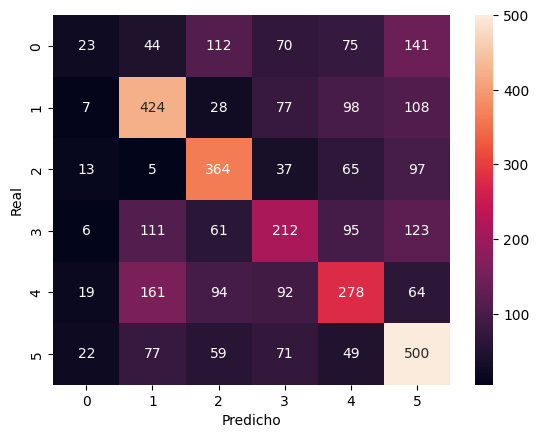

In [60]:
sns.heatmap(confusion_matrix(Y_test, gs_reg_log.best_estimator_.predict(X_test_scal)), annot= True, fmt = 'g')
plt.xlabel('Predicho')
plt.ylabel('Real');

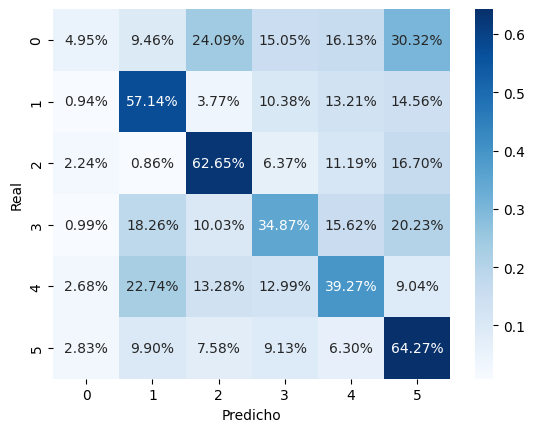

In [61]:
sns.heatmap(confusion_matrix(Y_test, gs_reg_log.best_estimator_.predict(X_test_scal), normalize='true'), annot=True, 
            fmt='.2%', cmap='Blues');
plt.xlabel('Predicho')
plt.ylabel('Real');

Conclusiones:

El modelo con regresión logística no es nada bueno en cuanto a accuracy, lo que podía presumirse haciendo un pairplot del dato, ya que la mayoría de variables no presentaban una relación lineal con el target en ninguna clase. Por ello, deberemos usar otro tipo de modelos de clasifiación.

En cuanto a la matriz de confusión, vemos que con el género que más se confunde es el 0 (pop), mientras que el que menos falla es el 5 (EDM), seguido de cerca del 2 (rock). 

Vemos que el modelo está teniendo muchos problemas a la hora de distinguir bien el género de pop. Esto puede deberse a que el pop es un género muy diverso, que presenta menos especificidades que los demás. Una posible solución sería subdividir esta clase en subgéneros de pop que sí tengan características más marcadas. Por ejemplo, pop lento, pop acústico o pop triste.

Vamos a probar este mismo modelo usando el dataframe resumido, es decir, el que contiene solo las variables que más distinguían entre clases. Este dataframe resumido viene de analizar las funciones de densidad de cada variable para cada clase de la categoría de género. Este análisis se ha hecho al final del notebook de limpieza de datos. Seguimos usando el modelo de regresión logística a pesar de que no sea el más adecuado para este dato, pero con el objetivo de tener una comparación de base con los demás dataframes posibles:

DATASET RESUMIDO:

In [62]:
X = generos_resumido.drop(columns={'genero'})
Y = generos_resumido['genero']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

escalador = StandardScaler()
escalador.fit(X_train, Y_train)
X_train_scal = escalador.transform(X_train)
X_test_scal = escalador.transform(X_test)

In [63]:
reg_log = LogisticRegression()

reg_log_param = {
    "penalty": ['l1', 'l2'],
    "C": [0.001, 0.01, 0.1, 1, 10],
    'solver' : ['saga', 'liblinear'],
    'max_iter' : [1000]
}

gs_reg_log = GridSearchCV(estimator=reg_log,
                         param_grid=reg_log_param,
                         cv = 2,
                         scoring = 'accuracy',
                         verbose = 1,
                         n_jobs = 4)

In [64]:
gs_reg_log.fit(X_train_scal, Y_train)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


GridSearchCV(cv=2, estimator=LogisticRegression(), n_jobs=4,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [1000],
                         'penalty': ['l1', 'l2'],
                         'solver': ['saga', 'liblinear']},
             scoring='accuracy', verbose=1)

In [65]:
print(gs_reg_log.best_params_)

{'C': 1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}


In [66]:
print('Accuracy en train: ', accuracy_score(Y_train, gs_reg_log.best_estimator_.predict(X_train_scal)))
print('Accuracy en test: ', accuracy_score(Y_test, gs_reg_log.best_estimator_.predict(X_test_scal)))

Accuracy en train:  0.41794409377817854
Accuracy en test:  0.4237506439979392


El modelo está teniendo métricas de accuracy peores que usando el dataframe completo. Esto se puede deber a que, a pesar de incluir mucho ruido, el hecho de usar todas las variables posibles está aportando algo más de información también, por lo que de ahora en adelante continuaremos usando el dataframe con todas sus variables. También podemos comprobar numéricamente que el modelo necesita algo más de complejidad, ya que con esos parámetros está cayendo en underfitting.

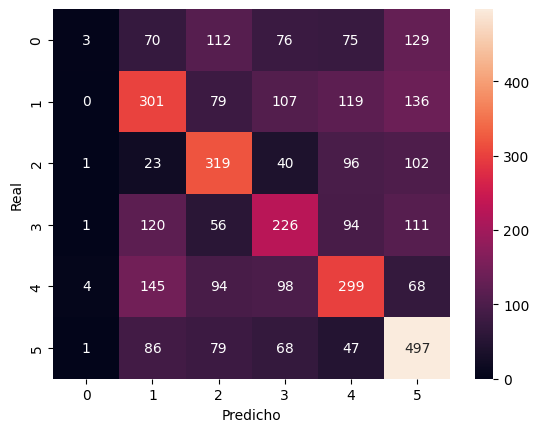

In [67]:
sns.heatmap(confusion_matrix(Y_test, gs_reg_log.best_estimator_.predict(X_test_scal)), annot= True, fmt = 'g')
plt.xlabel('Predicho')
plt.ylabel('Real');

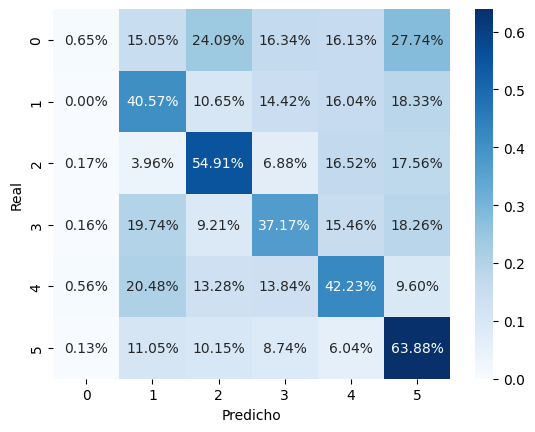

In [68]:
sns.heatmap(confusion_matrix(Y_test, gs_reg_log.best_estimator_.predict(X_test_scal), normalize='true'), annot=True, 
            fmt='.2%', cmap='Blues');
plt.xlabel('Predicho')
plt.ylabel('Real');

----

ANÁLISIS DE POP Y EDM

Vamos a analizar más en profundidad cuáles son las características que mejor definen al pop y al EDM, que son los géneros que más problemas está teniendo el modelo para diferenciar a la hora de hacer predicciones:

In [69]:
generos_todo.columns

Index(['bailable', 'energia', 'volumen', 'hablado', 'acustico', 'instrumental',
       'directo', 'valencia', 'popularidad', 'clave', 'modo', 'tempo',
       'genero'],
      dtype='object')

C:\Users\Ibai Valente Lavado\AppData\Local\Temp\ipykernel_13780\2295826840.py:4: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.kdeplot(data=generos_todo[(generos_todo['genero'] == 0) | (generos_todo['genero'] == 5)], x='bailable', hue='genero', fill=True, palette=colores, ax=axes[0,0])
C:\Users\Ibai Valente Lavado\AppData\Local\Temp\ipykernel_13780\2295826840.py:6: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.kdeplot(data=generos_todo[(generos_todo['genero'] == 0) | (generos_todo['genero'] == 5)], x='energia', hue='genero', fill=True, palette=colores, ax=axes[0,1])
C:\Users\Ibai Valente Lavado\AppData\Local\Temp\ipykernel_13780\2295826840.py:8: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.kdeplot(data=generos_todo[(generos_todo['genero'] == 0) | (generos_todo['genero'] == 5)], x='hablado', hue='genero', fill=True, palette=co

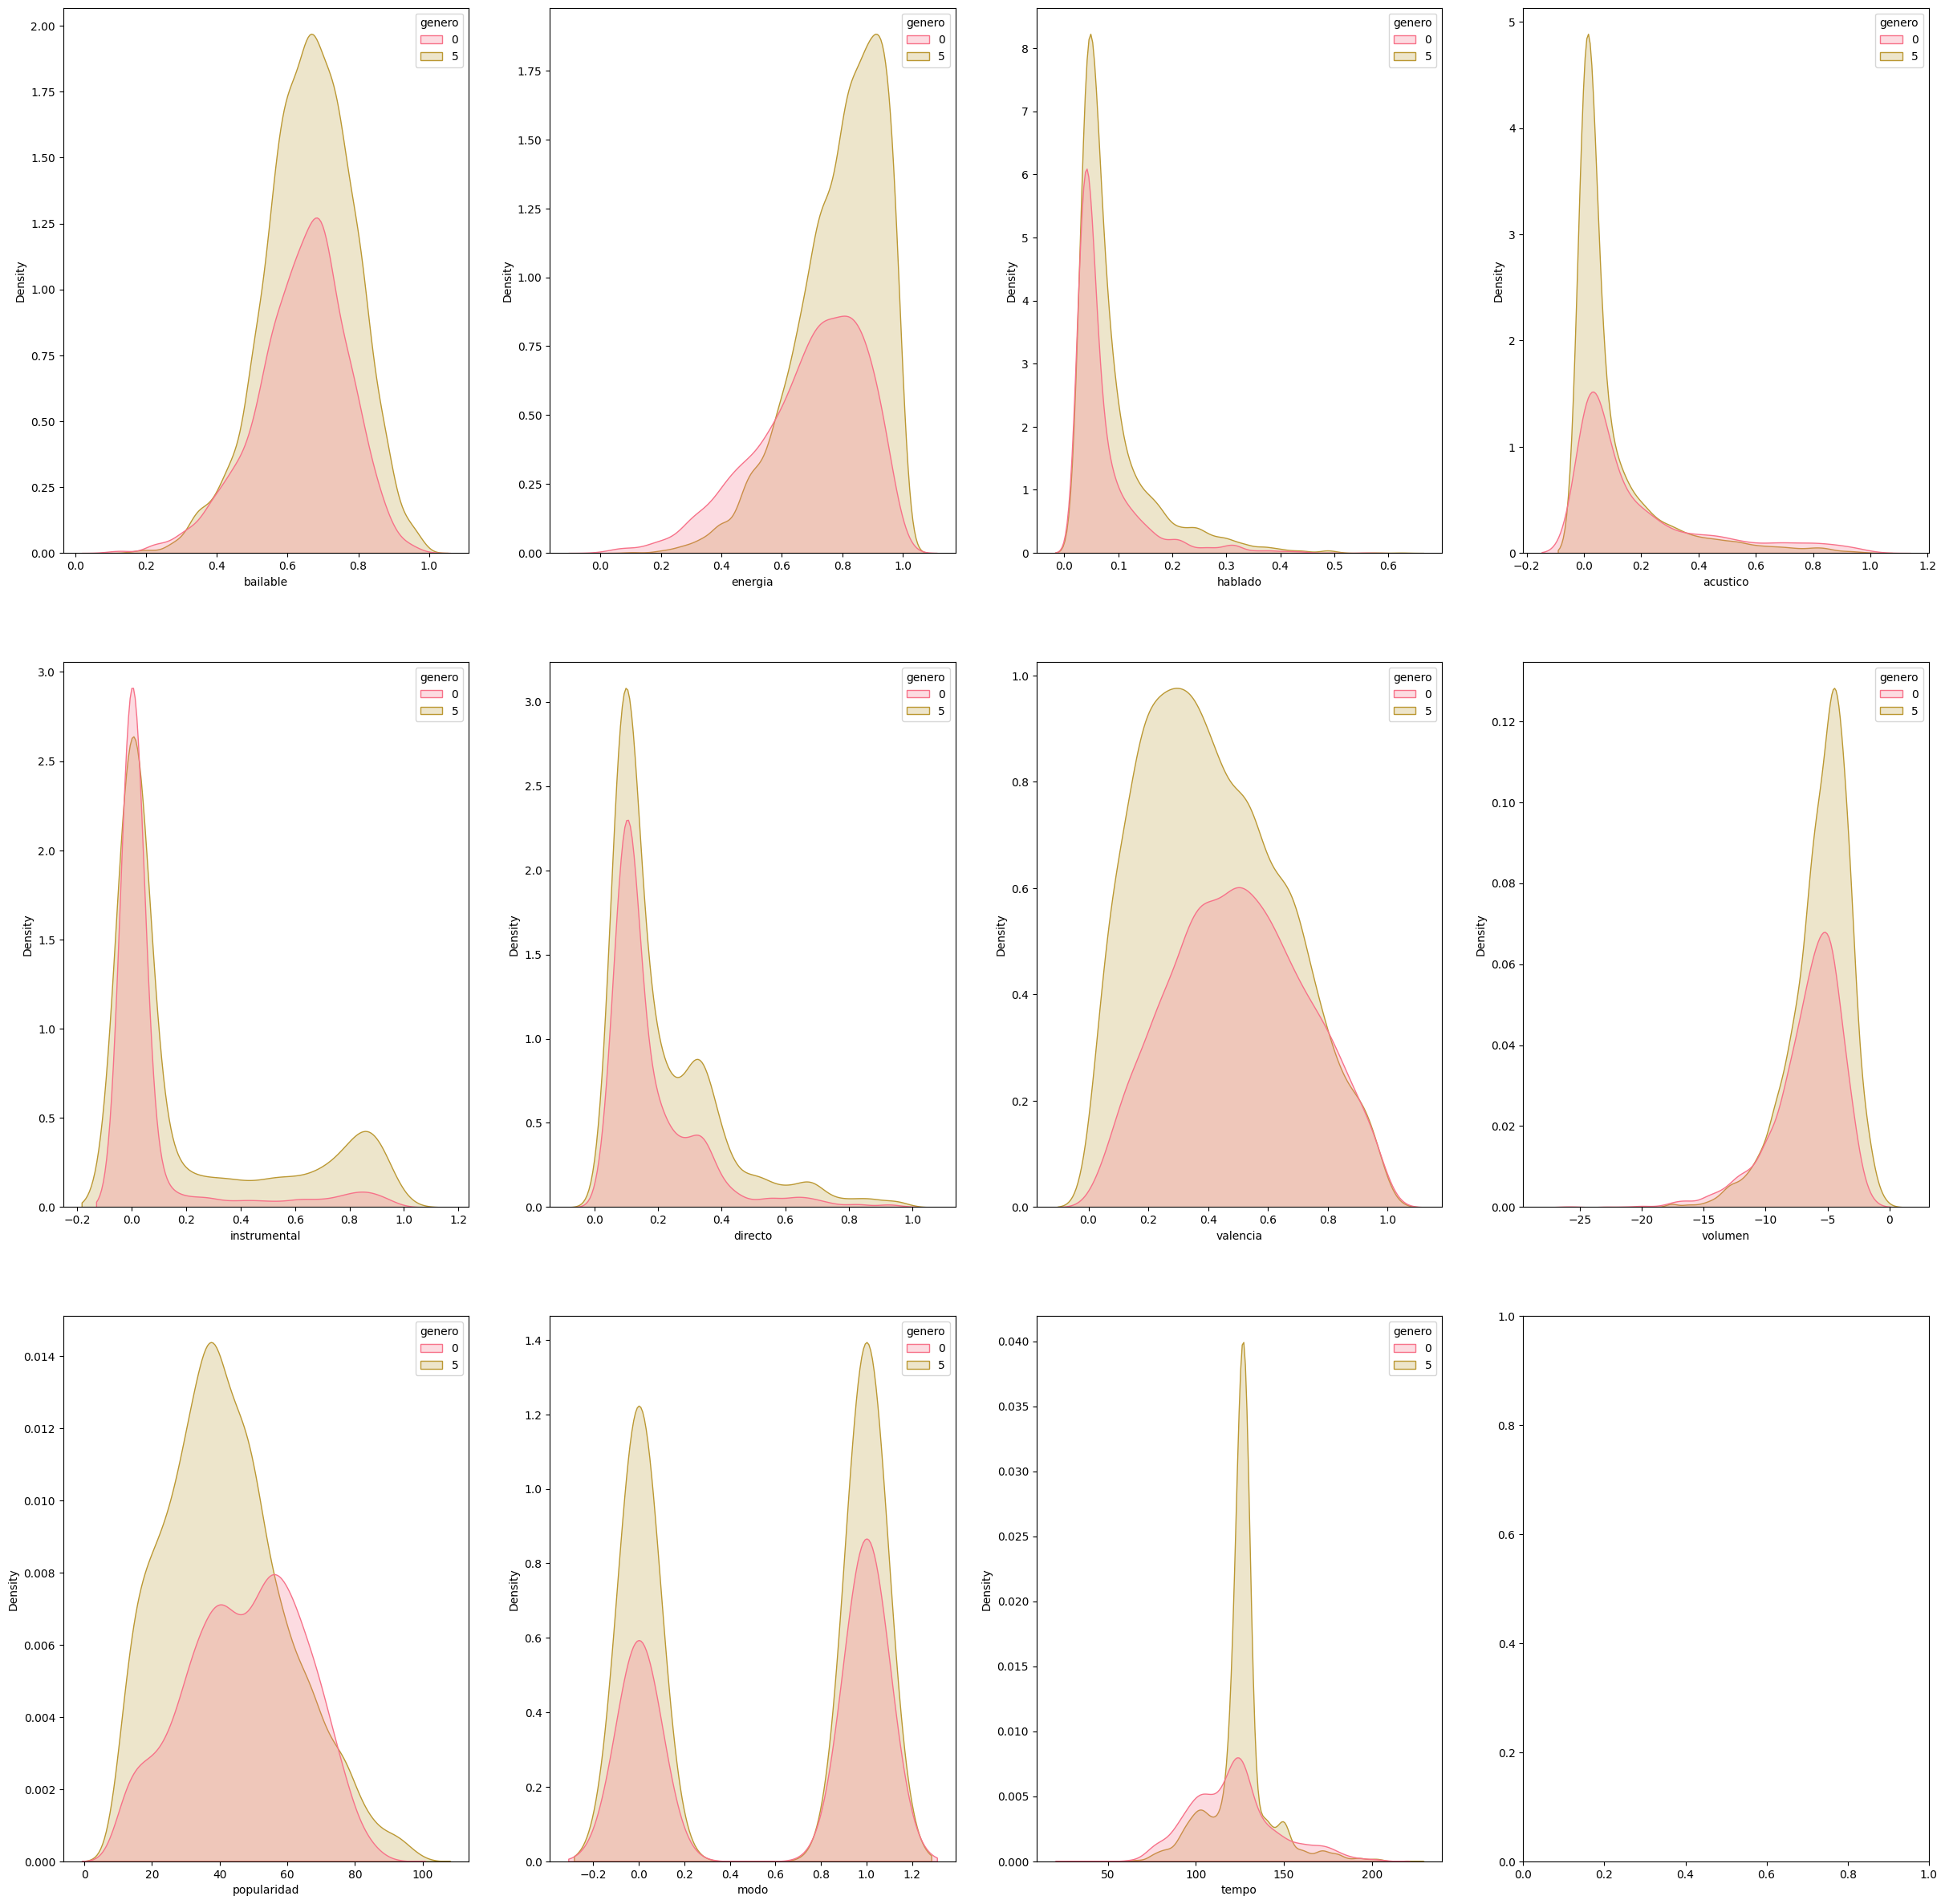

In [70]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(30, 30))
colores = sns.color_palette("husl", 6)

sns.kdeplot(data=generos_todo[(generos_todo['genero'] == 0) | (generos_todo['genero'] == 5)], x='bailable', hue='genero', fill=True, palette=colores, ax=axes[0,0])

sns.kdeplot(data=generos_todo[(generos_todo['genero'] == 0) | (generos_todo['genero'] == 5)], x='energia', hue='genero', fill=True, palette=colores, ax=axes[0,1])

sns.kdeplot(data=generos_todo[(generos_todo['genero'] == 0) | (generos_todo['genero'] == 5)], x='hablado', hue='genero', fill=True, palette=colores, ax=axes[0,2])

sns.kdeplot(data=generos_todo[(generos_todo['genero'] == 0) | (generos_todo['genero'] == 5)], x='acustico', hue='genero', fill=True, palette=colores, ax=axes[0,3])

sns.kdeplot(data=generos_todo[(generos_todo['genero'] == 0) | (generos_todo['genero'] == 5)], x='instrumental', hue='genero', fill=True, palette=colores, ax=axes[1,0])

sns.kdeplot(data=generos_todo[(generos_todo['genero'] == 0) | (generos_todo['genero'] == 5)], x='directo', hue='genero', fill=True, palette=colores, ax=axes[1,1])

sns.kdeplot(data=generos_todo[(generos_todo['genero'] == 0) | (generos_todo['genero'] == 5)], x='valencia', hue='genero', fill=True, palette=colores, ax=axes[1,2])

sns.kdeplot(data=generos_todo[(generos_todo['genero'] == 0) | (generos_todo['genero'] == 5)], x='volumen', hue='genero', fill=True, palette=colores, ax=axes[1,3])

sns.kdeplot(data=generos_todo[(generos_todo['genero'] == 0) | (generos_todo['genero'] == 5)], x='popularidad', hue='genero', fill=True, palette=colores, ax=axes[2,0])

sns.kdeplot(data=generos_todo[(generos_todo['genero'] == 0) | (generos_todo['genero'] == 5)], x='modo', hue='genero', fill=True, palette=colores, ax=axes[2,1])

sns.kdeplot(data=generos_todo[(generos_todo['genero'] == 0) | (generos_todo['genero'] == 5)], x='tempo', hue='genero', fill=True, palette=colores, ax=axes[2,2])

plt.show();

Como podemos ver, pop y edm contienen características parecidas en algunas variables. Sin embargo, en otras sí que parecen diferenciarse bastante por lo que es complicado adivinar la razón por la que el modelo está teniendo tantos problemas a la hora de distinguir entre ambos.

Volvemos al notebook de limpieza de datos para analizar cómo son los subgéneros de pop y ver si podemos intentar subdividir el género para sacar mejores resultados

----

VUELVE DEL NOTEBOOK DE LIMPIEZA:

Ya hemos conseguido quitar los subgéneros que contenían géneros cruzados. Veamos si los modelos consiguen mejorar algo

In [71]:
X = generos_sin_mezclas.drop(columns={'genero'})
Y = generos_sin_mezclas['genero']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

escalador = StandardScaler()
escalador.fit(X_train, Y_train)
X_train_scal = escalador.transform(X_train)
X_test_scal = escalador.transform(X_test)

In [72]:
reg_log = LogisticRegression()

reg_log_param = {
    "penalty": ['l1', 'l2'],
    "C": [0.001, 0.01, 0.1, 1, 10],
    'solver' : ['saga', 'liblinear'],
    'max_iter' : [1000]
}

gs_reg_log = GridSearchCV(estimator=reg_log,
                         param_grid=reg_log_param,
                         cv = 2,
                         scoring = 'accuracy',
                         verbose = 1,
                         n_jobs = 4)

In [73]:
gs_reg_log.fit(X_train_scal, Y_train)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


GridSearchCV(cv=2, estimator=LogisticRegression(), n_jobs=4,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [1000],
                         'penalty': ['l1', 'l2'],
                         'solver': ['saga', 'liblinear']},
             scoring='accuracy', verbose=1)

In [74]:
print('Accuracy en train: ', accuracy_score(Y_train, gs_reg_log.best_estimator_.predict(X_train_scal)))
print('Accuracy en test: ', accuracy_score(Y_test, gs_reg_log.best_estimator_.predict(X_test_scal)))

Accuracy en train:  0.4978877489438745
Accuracy en test:  0.5001508295625943


El modelo ha conseguido mejorar un poco en cuanto a train y test comparado con el modelo que incluía las canciones con subgéneros mezclados así que podríamos proseguir usando el dataframe sin mezclas de géneros en el subgénero

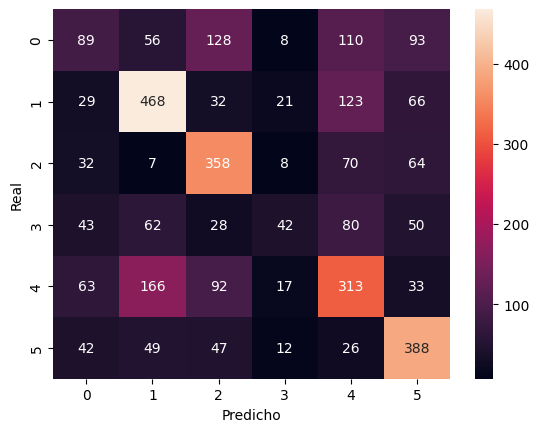

In [75]:
sns.heatmap(confusion_matrix(Y_test, gs_reg_log.best_estimator_.predict(X_test_scal)), annot= True, fmt = 'g')
plt.xlabel('Predicho')
plt.ylabel('Real');

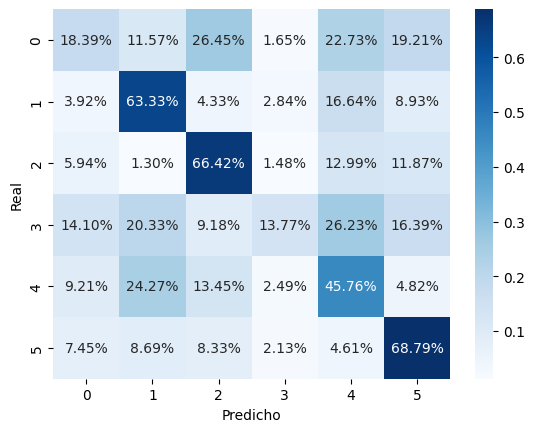

In [76]:
sns.heatmap(confusion_matrix(Y_test, gs_reg_log.best_estimator_.predict(X_test_scal), normalize='true'), annot=True, 
            fmt='.2%', cmap='Blues');
plt.xlabel('Predicho')
plt.ylabel('Real');

#### GÉNEROS BIEN Y MAL PREDICHOS

En la mayoría de modelos y dataframes que hemos probado podemos ver que existe una diferencia muy grande entre la precisión con la que predice el modelo unos géneros y otros. Por lo general, todos los modelos tienden a predecir mejor los géneros de rap, rock y EDM, mientras que tienen más dificultades prediciendo bien los géneros pop, latin y R&B. 

Visto esto, podríamos intentar dividir nuestro dataframe en dos y hacer un modelo para cada subset:

1. MODELO CON GÉNEROS BIEN PREDICHOS

In [79]:
X_buenos = generos_buenos.drop(columns={'genero'})
Y_buenos = generos_buenos['genero']

X_train_buenos, X_test_buenos, Y_train_buenos, Y_test_buenos = train_test_split(X_buenos, Y_buenos, test_size=0.2, random_state=42)

escalador = StandardScaler()
escalador.fit(X_train_buenos, Y_train_buenos)
X_train_buenos_scal = escalador.transform(X_train_buenos)
X_test_buenos_scal = escalador.transform(X_test_buenos)

In [78]:
reg_log = LogisticRegression()

reg_log_param = {
    "penalty": ['l1', 'l2'],
    "C": [0.001, 0.01, 0.1, 1, 10],
    'solver' : ['saga', 'liblinear'],
    'max_iter' : [1000]
}

gs_reg_log = GridSearchCV(estimator=reg_log,
                         param_grid=reg_log_param,
                         cv = 2,
                         scoring = 'accuracy',
                         verbose = 1,
                         n_jobs = 4)

In [80]:
gs_reg_log.fit(X_train_buenos_scal, Y_train_buenos)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


GridSearchCV(cv=2, estimator=LogisticRegression(), n_jobs=4,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [1000],
                         'penalty': ['l1', 'l2'],
                         'solver': ['saga', 'liblinear']},
             scoring='accuracy', verbose=1)

In [81]:
print('Accuracy en train: ', accuracy_score(Y_train_buenos, gs_reg_log.best_estimator_.predict(X_train_buenos_scal)))
print('Accuracy en test: ', accuracy_score(Y_test_buenos, gs_reg_log.best_estimator_.predict(X_test_buenos_scal)))

Accuracy en train:  0.7776734200992889
Accuracy en test:  0.7837982832618026


Vemos que el accuracy con los géneros que reconocía bien es mucho más alto que en general

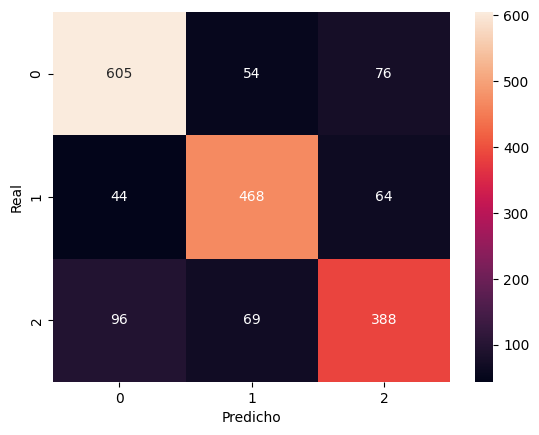

In [83]:
sns.heatmap(confusion_matrix(Y_test_buenos, gs_reg_log.best_estimator_.predict(X_test_buenos_scal)), annot= True, fmt = 'g')
plt.xlabel('Predicho')
plt.ylabel('Real');

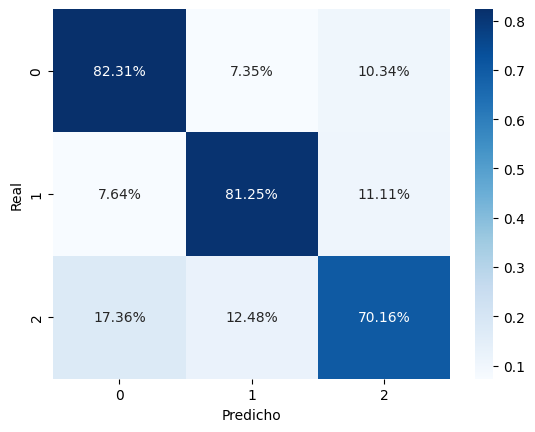

In [84]:
sns.heatmap(confusion_matrix(Y_test_buenos, gs_reg_log.best_estimator_.predict(X_test_buenos_scal), normalize='true'), annot=True, 
            fmt='.2%', cmap='Blues');
plt.xlabel('Predicho')
plt.ylabel('Real');

El accuracy con los 3 géneros que mejor se predicen en general ha aumentado mucho. Vemos incluso que usando un modelo de regresión logística estamos consiguiendo resultados decentes, por lo que tenemos margen para probar modelos más complejos que puedan mejorar aún más. Además, en la matriz de confusión normalizada podemos ver que los verdaderos positivos están bastante concentrados, que el modelo cuando predice un género la gran mayoría de las veces sí se trata del mismo.

2. MODELO CON GÉNEROS MALOS

In [86]:
X_malos = generos_malos.drop(columns={'genero'})
Y_malos = generos_malos['genero']

X_train_malos, X_test_malos, Y_train_malos, Y_test_malos = train_test_split(X_malos, Y_malos, test_size=0.2, random_state=42)

escalador = StandardScaler()
escalador.fit(X_train_malos, Y_train_malos)
X_train_malos_scal = escalador.transform(X_train_malos)
X_test_malos_scal = escalador.transform(X_test_malos)

In [87]:
reg_log = LogisticRegression()

reg_log_param = {
    "penalty": ['l1', 'l2'],
    "C": [0.001, 0.01, 0.1, 1, 10],
    'solver' : ['saga', 'liblinear'],
    'max_iter' : [1000]
}

gs_reg_log = GridSearchCV(estimator=reg_log,
                         param_grid=reg_log_param,
                         cv = 2,
                         scoring = 'accuracy',
                         verbose = 1,
                         n_jobs = 4)

In [88]:
gs_reg_log.fit(X_train_malos_scal, Y_train_malos)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


GridSearchCV(cv=2, estimator=LogisticRegression(), n_jobs=4,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [1000],
                         'penalty': ['l1', 'l2'],
                         'solver': ['saga', 'liblinear']},
             scoring='accuracy', verbose=1)

In [89]:
print('Accuracy en train: ', accuracy_score(Y_train_malos, gs_reg_log.best_estimator_.predict(X_train_malos_scal)))
print('Accuracy en test: ', accuracy_score(Y_test_malos, gs_reg_log.best_estimator_.predict(X_test_malos_scal)))

Accuracy en train:  0.5891780113734275
Accuracy en test:  0.5761543762922122


Vamos mejorando las métricas poco a poco

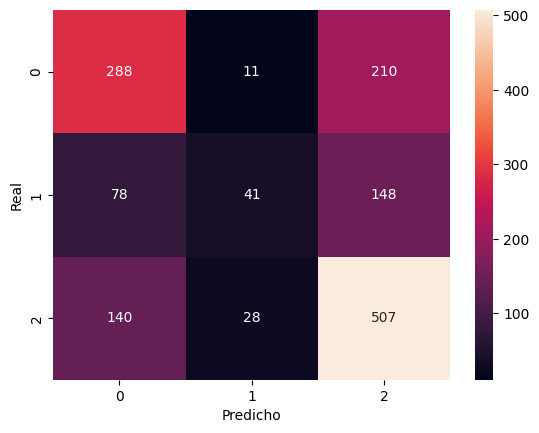

In [90]:
sns.heatmap(confusion_matrix(Y_test_malos, gs_reg_log.best_estimator_.predict(X_test_malos_scal)), annot= True, fmt = 'g')
plt.xlabel('Predicho')
plt.ylabel('Real');

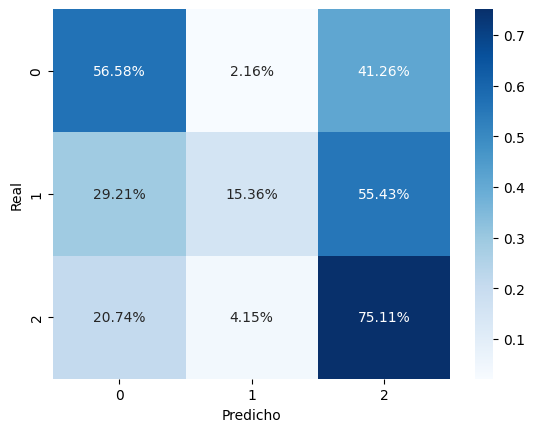

In [91]:
sns.heatmap(confusion_matrix(Y_test_malos, gs_reg_log.best_estimator_.predict(X_test_malos_scal), normalize='true'), annot=True, 
            fmt='.2%', cmap='Blues');
plt.xlabel('Predicho')
plt.ylabel('Real');

Curiosamente, ahora el modelo está teniendo más dificultades identificando el género de latin. Cuando una canción es de género latin, el modelo piensa antes que se trata de R&B, después de pop y finalmente de latin.

Comprobamos que en el caso de los géneros que peor se predecían, conseguimos mejores resultados habiendo dividido el dataframe. Sigue teniendo bastantes problemas a la hora de identificar ciertos géneros, como podemos ver en la matriz de confusión normalizada. Seguiremos probando modelos más complejos para ver si podemos mejorar los resultados

----

### RANDOM FOREST

Al tratarse de un modelo no paramétrico, los árboles de decisión hacen muy pocas suposiciones sobre los datos de entrenamiento, a diferencia de los modelos lineales que asumen que los datos tienen una relación lineal. Por lo tanto, la estructura del modelo es libre de ajustarse todo lo posible a los datos de entrenamiento. Probaremos este tipo de modelo, para ver si actúa mejor con nuestro dato. Primero vamos a probar el dataset completo (que de ahora en adelante llamaremos "sin mezclas" ya que no incluye subgéneros que tengan géneros mezclados, como hemos visto que funcionaba mejor así)

In [3]:
X_sin_mezclas = generos_sin_mezclas.drop(columns={'genero'})
Y_sin_mezclas = generos_sin_mezclas['genero']

X_train_sin_mezclas, X_test_sin_mezclas, Y_train_sin_mezclas, Y_test_sin_mezclas = train_test_split(X_sin_mezclas, Y_sin_mezclas, test_size=0.2, random_state=42)

In [4]:
bosque = RandomForestClassifier()

bosque_param = {
    "n_estimators": [10, 20, 30],
    'max_depth' : [2, 5, 10],
    'max_features' : ['log2']
}

gs_bosque = GridSearchCV(estimator=bosque,
                         param_grid=bosque_param,
                         cv = 3,
                         scoring = 'accuracy',
                         verbose = 1,
                         n_jobs = 4)

In [5]:
gs_bosque.fit(X_train_sin_mezclas, Y_train_sin_mezclas)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'max_depth': [2, 5, 10], 'max_features': ['log2'],
                         'n_estimators': [10, 20, 30]},
             scoring='accuracy', verbose=1)

In [6]:
print(gs_bosque.best_params_)

{'max_depth': 10, 'max_features': 'log2', 'n_estimators': 30}


In [7]:
print('Accuracy en train: ', accuracy_score(Y_train_sin_mezclas, gs_bosque.best_estimator_.predict(X_train_sin_mezclas)))
print('Accuracy en test: ', accuracy_score(Y_test_sin_mezclas, gs_bosque.best_estimator_.predict(X_test_sin_mezclas)))

Accuracy en train:  0.7312914906457453
Accuracy en test:  0.5631975867269985


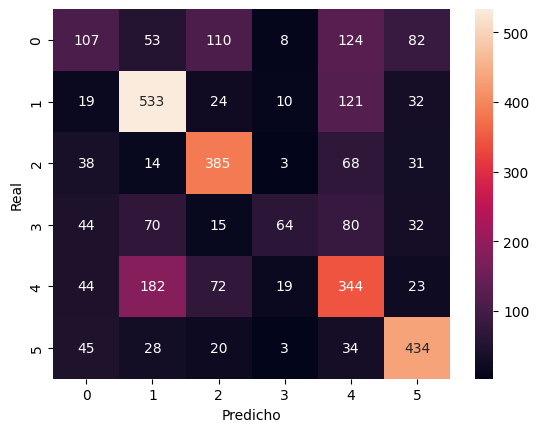

In [8]:
sns.heatmap(confusion_matrix(Y_test_sin_mezclas, gs_bosque.best_estimator_.predict(X_test_sin_mezclas)), annot= True, fmt = 'g')
plt.xlabel('Predicho')
plt.ylabel('Real');

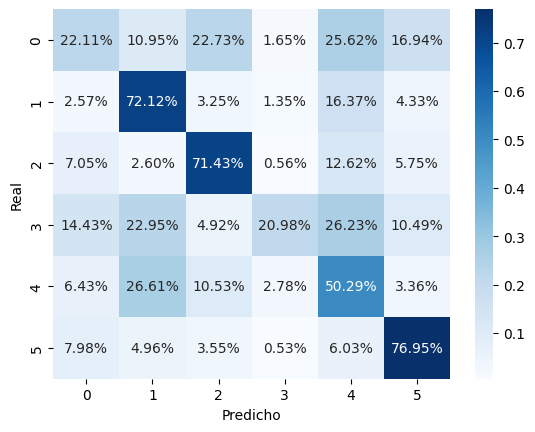

In [9]:
sns.heatmap(confusion_matrix(Y_test_sin_mezclas, gs_bosque.best_estimator_.predict(X_test_sin_mezclas), normalize='true'), annot=True, 
            fmt='.2%', cmap='Blues');
plt.xlabel('Predicho')
plt.ylabel('Real');

El modelo de random forest ha conseguido mejores métricas que el de regresión logística

1. MODELOS CON GÉNEROS BIEN PREDICHOS

In [12]:
X_buenos = generos_buenos.drop(columns={'genero'})
Y_buenos = generos_buenos['genero']

X_train_buenos, X_test_buenos, Y_train_buenos, Y_test_buenos = train_test_split(X_buenos, Y_buenos, test_size=0.2, random_state=42)

In [13]:
bosque = RandomForestClassifier()

bosque_param = {
    "n_estimators": [10, 20, 30],
    'max_depth' : [2, 5, 10],
    'max_features' : ['log2']
}

gs_bosque = GridSearchCV(estimator=bosque,
                         param_grid=bosque_param,
                         cv = 3,
                         scoring = 'accuracy',
                         verbose = 1,
                         n_jobs = 4)

In [14]:
gs_bosque.fit(X_train_buenos, Y_train_buenos)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'max_depth': [2, 5, 10], 'max_features': ['log2'],
                         'n_estimators': [10, 20, 30]},
             scoring='accuracy', verbose=1)

In [15]:
print(gs_bosque.best_params_)

{'max_depth': 10, 'max_features': 'log2', 'n_estimators': 30}


In [16]:
print('Accuracy en train: ', accuracy_score(Y_train_buenos, gs_bosque.best_estimator_.predict(X_train_buenos)))
print('Accuracy en test: ', accuracy_score(Y_test_buenos, gs_bosque.best_estimator_.predict(X_test_buenos)))

Accuracy en train:  0.9384140614517644
Accuracy en test:  0.8562231759656652


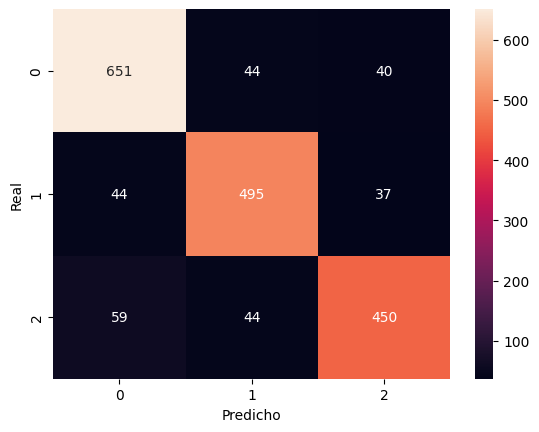

In [17]:
sns.heatmap(confusion_matrix(Y_test_buenos, gs_bosque.best_estimator_.predict(X_test_buenos)), annot= True, fmt = 'g')
plt.xlabel('Predicho')
plt.ylabel('Real');

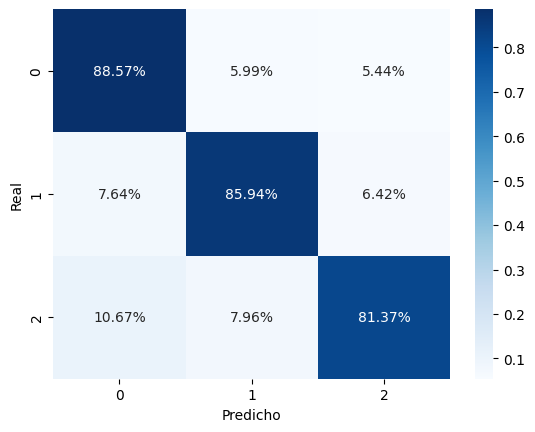

In [18]:
sns.heatmap(confusion_matrix(Y_test_buenos, gs_bosque.best_estimator_.predict(X_test_buenos), normalize='true'), annot=True, 
            fmt='.2%', cmap='Blues');
plt.xlabel('Predicho')
plt.ylabel('Real');

2. MODELOS CON GÉNEROS MAL PREDICHOS

In [19]:
X_malos = generos_malos.drop(columns={'genero'})
Y_malos = generos_malos['genero']

X_train_malos, X_test_malos, Y_train_malos, Y_test_malos = train_test_split(X_malos, Y_malos, test_size=0.2, random_state=42)

In [20]:
bosque = RandomForestClassifier()

bosque_param = {
    "n_estimators": [10, 20, 30],
    'max_depth' : [2, 5, 10],
    'max_features' : ['log2']
}

gs_bosque = GridSearchCV(estimator=bosque,
                         param_grid=bosque_param,
                         cv = 3,
                         scoring = 'accuracy',
                         verbose = 1,
                         n_jobs = 4)

In [21]:
gs_bosque.fit(X_train_malos, Y_train_malos)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'max_depth': [2, 5, 10], 'max_features': ['log2'],
                         'n_estimators': [10, 20, 30]},
             scoring='accuracy', verbose=1)

In [22]:
print(gs_bosque.best_params_)

{'max_depth': 10, 'max_features': 'log2', 'n_estimators': 30}


In [23]:
print('Accuracy en train: ', accuracy_score(Y_train_malos, gs_bosque.best_estimator_.predict(X_train_malos)))
print('Accuracy en test: ', accuracy_score(Y_test_malos, gs_bosque.best_estimator_.predict(X_test_malos)))

Accuracy en train:  0.8140616922281578
Accuracy en test:  0.6161268090971743


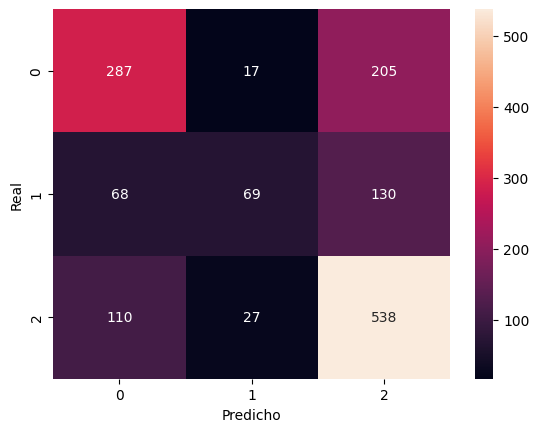

In [24]:
sns.heatmap(confusion_matrix(Y_test_malos, gs_bosque.best_estimator_.predict(X_test_malos)), annot= True, fmt = 'g')
plt.xlabel('Predicho')
plt.ylabel('Real');

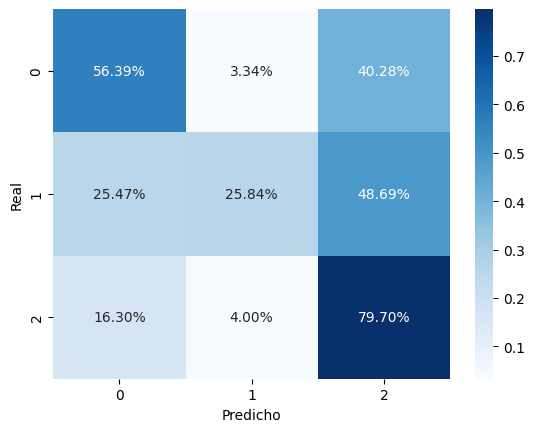

In [25]:
sns.heatmap(confusion_matrix(Y_test_malos, gs_bosque.best_estimator_.predict(X_test_malos), normalize='true'), annot=True, 
            fmt='.2%', cmap='Blues');
plt.xlabel('Predicho')
plt.ylabel('Real');

Sigue teniendo muchos problemas a la hora de identificar el el género 1, es decir, latin. La mayoría de las veces dice que es género 2. Aun así las métricas de accuracy han mejorado

----

### XGBOOSTING

In [26]:
X_sin_mezclas = generos_sin_mezclas.drop(columns={'genero'})
Y_sin_mezclas = generos_sin_mezclas['genero']

X_train_sin_mezclas, X_test_sin_mezclas, Y_train_sin_mezclas, Y_test_sin_mezclas = train_test_split(X_sin_mezclas, Y_sin_mezclas, test_size=0.2, random_state=42)

In [27]:
xgb = xgboost.XGBRFClassifier()

params = {'booster' : ['gbtree'],
          'eta' : [0.01, 0.05, 0.1, 0.2],
          'max_depth' : [3, 5, 10],
          'objective' : ['multi:softprob'],
          'num_class' : [6],
          'eval_metric' : ['mlogloss']}

gs_xgb = GridSearchCV(estimator=xgb,
                      param_grid=params,
                      cv=2,
                      scoring='accuracy',
                      verbose=1,
                      n_jobs=4)

In [28]:
gs_xgb.fit(X_train_sin_mezclas, Y_train_sin_mezclas)

Fitting 2 folds for each of 12 candidates, totalling 24 fits


GridSearchCV(cv=2,
             estimator=XGBRFClassifier(base_score=None, booster=None,
                                       callbacks=None, colsample_bylevel=None,
                                       colsample_bytree=None, device=None,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, feature_types=None,
                                       gamma=None, grow_policy=None,
                                       importance_type=None,
                                       interaction_constraints=None,
                                       max_bin=None, max_cat_threshold=None,
                                       max...
                                       missing=nan, monotone_constraints=None,
                                       multi_strategy=None, n_estimators=None,
                                       n_jobs=None, num_parallel_tree=None,
                                       objective='binary:logistic',
                                       random_state=None, reg_alpha=None, ...),
             n_jobs=4,
             param_grid={'booster': ['gbtree'], 'eta': [0.01, 0.05, 0.1, 0.2],
                         'eval_metric': ['mlogloss'], 'max_depth': [3, 5, 10],
                         'num_class': [6], 'objective': ['multi:softprob']},
             scoring='accuracy', verbose=1)

In [29]:
print(gs_xgb.best_params_)

{'booster': 'gbtree', 'eta': 0.01, 'eval_metric': 'mlogloss', 'max_depth': 10, 'num_class': 6, 'objective': 'multi:softprob'}


In [30]:
print('Accuracy en train: ', accuracy_score(Y_train_sin_mezclas, gs_xgb.best_estimator_.predict(X_train_sin_mezclas)))
print('Accuracy en test: ', accuracy_score(Y_test_sin_mezclas, gs_xgb.best_estimator_.predict(X_test_sin_mezclas)))

Accuracy en train:  0.8224200362100181
Accuracy en test:  0.5734539969834087


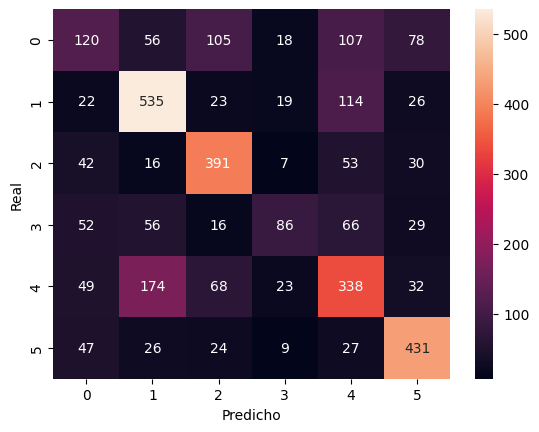

In [31]:
sns.heatmap(confusion_matrix(Y_test_sin_mezclas, gs_xgb.best_estimator_.predict(X_test_sin_mezclas)), annot= True, fmt = 'g')
plt.xlabel('Predicho')
plt.ylabel('Real');

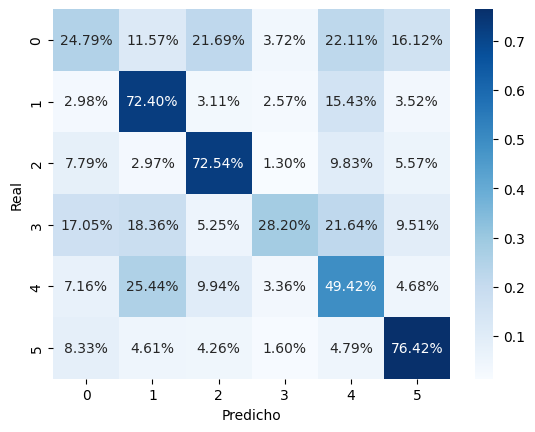

In [32]:
sns.heatmap(confusion_matrix(Y_test_sin_mezclas, gs_xgb.best_estimator_.predict(X_test_sin_mezclas), normalize='true'), annot=True, 
            fmt='.2%', cmap='Blues');
plt.xlabel('Predicho')
plt.ylabel('Real');

1. MODELO CON GÉNEROS BUENOS

In [33]:
X_buenos = generos_buenos.drop(columns={'genero'})
Y_buenos = generos_buenos['genero']

X_train_buenos, X_test_buenos, Y_train_buenos, Y_test_buenos = train_test_split(X_buenos, Y_buenos, test_size=0.2, random_state=42)

In [34]:
xgb = xgboost.XGBRFClassifier()

params = {'booster' : ['gbtree'],
          'eta' : [0.01, 0.05, 0.1, 0.2],
          'max_depth' : [3, 5, 10],
          'objective' : ['multi:softprob'],
          'num_class' : [3],
          'eval_metric' : ['mlogloss']}

gs_xgb = GridSearchCV(estimator=xgb,
                      param_grid=params,
                      cv=2,
                      scoring='accuracy',
                      verbose=1,
                      n_jobs=4)

In [35]:
gs_xgb.fit(X_train_buenos, Y_train_buenos)

Fitting 2 folds for each of 12 candidates, totalling 24 fits


GridSearchCV(cv=2,
             estimator=XGBRFClassifier(base_score=None, booster=None,
                                       callbacks=None, colsample_bylevel=None,
                                       colsample_bytree=None, device=None,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, feature_types=None,
                                       gamma=None, grow_policy=None,
                                       importance_type=None,
                                       interaction_constraints=None,
                                       max_bin=None, max_cat_threshold=None,
                                       max...
                                       missing=nan, monotone_constraints=None,
                                       multi_strategy=None, n_estimators=None,
                                       n_jobs=None, num_parallel_tree=None,
                                       objective='binary:logistic',
                                       random_state=None, reg_alpha=None, ...),
             n_jobs=4,
             param_grid={'booster': ['gbtree'], 'eta': [0.01, 0.05, 0.1, 0.2],
                         'eval_metric': ['mlogloss'], 'max_depth': [3, 5, 10],
                         'num_class': [3], 'objective': ['multi:softprob']},
             scoring='accuracy', verbose=1)

In [36]:
print(gs_xgb.best_params_)

{'booster': 'gbtree', 'eta': 0.01, 'eval_metric': 'mlogloss', 'max_depth': 10, 'num_class': 3, 'objective': 'multi:softprob'}


In [37]:
print('Accuracy en train: ', accuracy_score(Y_train_buenos, gs_xgb.best_estimator_.predict(X_train_buenos)))
print('Accuracy en test: ', accuracy_score(Y_test_buenos, gs_xgb.best_estimator_.predict(X_test_buenos)))

Accuracy en train:  0.961894539111767
Accuracy en test:  0.8594420600858369


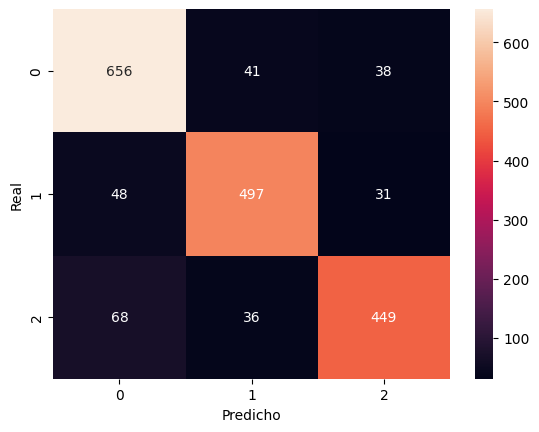

In [38]:
sns.heatmap(confusion_matrix(Y_test_buenos, gs_xgb.best_estimator_.predict(X_test_buenos)), annot= True, fmt = 'g')
plt.xlabel('Predicho')
plt.ylabel('Real');

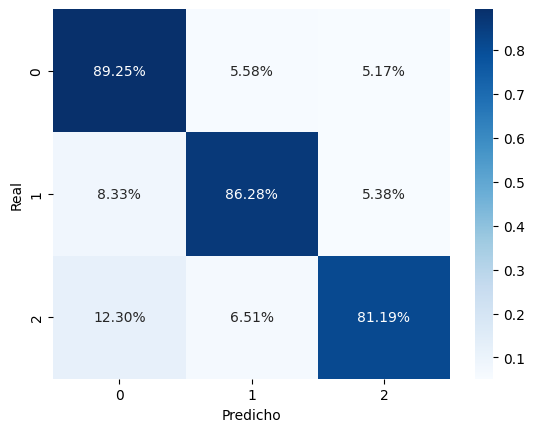

In [39]:
sns.heatmap(confusion_matrix(Y_test_buenos, gs_xgb.best_estimator_.predict(X_test_buenos), normalize='true'), annot=True, 
            fmt='.2%', cmap='Blues');
plt.xlabel('Predicho')
plt.ylabel('Real');

2. MODELO CON GÉNEROS MALOS

In [40]:
X_malos = generos_malos.drop(columns={'genero'})
Y_malos = generos_malos['genero']

X_train_malos, X_test_malos, Y_train_malos, Y_test_malos = train_test_split(X_malos, Y_malos, test_size=0.2, random_state=42)

In [41]:
xgb = xgboost.XGBRFClassifier()

params = {'booster' : ['gbtree'],
          'eta' : [0.01, 0.05, 0.1, 0.2],
          'max_depth' : [3, 5, 10],
          'objective' : ['multi:softprob'],
          'num_class' : [3],
          'eval_metric' : ['mlogloss']}

gs_xgb = GridSearchCV(estimator=xgb,
                      param_grid=params,
                      cv=2,
                      scoring='accuracy',
                      verbose=1,
                      n_jobs=4)

In [42]:
gs_xgb.fit(X_train_malos, Y_train_malos)

Fitting 2 folds for each of 12 candidates, totalling 24 fits


GridSearchCV(cv=2,
             estimator=XGBRFClassifier(base_score=None, booster=None,
                                       callbacks=None, colsample_bylevel=None,
                                       colsample_bytree=None, device=None,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, feature_types=None,
                                       gamma=None, grow_policy=None,
                                       importance_type=None,
                                       interaction_constraints=None,
                                       max_bin=None, max_cat_threshold=None,
                                       max...
                                       missing=nan, monotone_constraints=None,
                                       multi_strategy=None, n_estimators=None,
                                       n_jobs=None, num_parallel_tree=None,
                                       objective='binary:logistic',
                                       random_state=None, reg_alpha=None, ...),
             n_jobs=4,
             param_grid={'booster': ['gbtree'], 'eta': [0.01, 0.05, 0.1, 0.2],
                         'eval_metric': ['mlogloss'], 'max_depth': [3, 5, 10],
                         'num_class': [3], 'objective': ['multi:softprob']},
             scoring='accuracy', verbose=1)

In [43]:
print(gs_xgb.best_params_)

{'booster': 'gbtree', 'eta': 0.01, 'eval_metric': 'mlogloss', 'max_depth': 10, 'num_class': 3, 'objective': 'multi:softprob'}


In [44]:
print('Accuracy en train: ', accuracy_score(Y_train_malos, gs_xgb.best_estimator_.predict(X_train_malos)))
print('Accuracy en test: ', accuracy_score(Y_test_malos, gs_xgb.best_estimator_.predict(X_test_malos)))

Accuracy en train:  0.8583491297604687
Accuracy en test:  0.6368022053756031


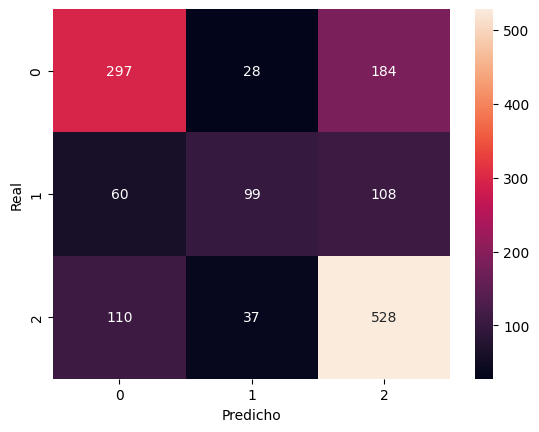

In [45]:
sns.heatmap(confusion_matrix(Y_test_malos, gs_xgb.best_estimator_.predict(X_test_malos)), annot= True, fmt = 'g')
plt.xlabel('Predicho')
plt.ylabel('Real');

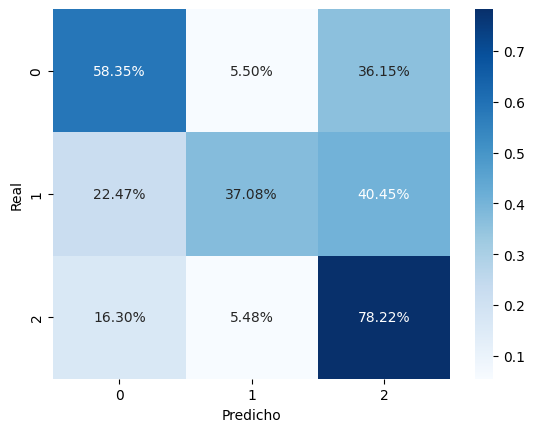

In [46]:
sns.heatmap(confusion_matrix(Y_test_malos, gs_xgb.best_estimator_.predict(X_test_malos), normalize='true'), annot=True, 
            fmt='.2%', cmap='Blues');
plt.xlabel('Predicho')
plt.ylabel('Real');

Como vemos, entre los géneros mal predichos, todos los algoritmos están teniendo más problemas con el género 1, el latin. Vamos a intentar ajustar los pesos que le asigna el algoritmo para que reconozca mejor esta clase:

In [47]:
xgb = xgboost.XGBRFClassifier()

pesos = [1, 1.05, 1] # le damos el mismo peso a pop y R&B, y algo más de peso a latin para intentar que lo reconozca mejor

params = {'booster' : ['gbtree'],
          'eta' : [0.01, 0.05, 0.1, 0.2],
          'max_depth' : [3, 5, 10],
          'objective' : ['multi:softprob'],
          'num_class' : [3],
          'eval_metric' : ['mlogloss']}

gs_xgb = GridSearchCV(estimator=xgb,
                      param_grid=params,
                      cv=2,
                      scoring='accuracy',
                      verbose=1,
                      n_jobs=4)

In [48]:
gs_xgb.fit(X_train_malos, Y_train_malos, sample_weight=[pesos[label] for label in Y_train_malos])

Fitting 2 folds for each of 12 candidates, totalling 24 fits


GridSearchCV(cv=2,
             estimator=XGBRFClassifier(base_score=None, booster=None,
                                       callbacks=None, colsample_bylevel=None,
                                       colsample_bytree=None, device=None,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, feature_types=None,
                                       gamma=None, grow_policy=None,
                                       importance_type=None,
                                       interaction_constraints=None,
                                       max_bin=None, max_cat_threshold=None,
                                       max...
                                       missing=nan, monotone_constraints=None,
                                       multi_strategy=None, n_estimators=None,
                                       n_jobs=None, num_parallel_tree=None,
                                       objective='binary:logistic',
                                       random_state=None, reg_alpha=None, ...),
             n_jobs=4,
             param_grid={'booster': ['gbtree'], 'eta': [0.01, 0.05, 0.1, 0.2],
                         'eval_metric': ['mlogloss'], 'max_depth': [3, 5, 10],
                         'num_class': [3], 'objective': ['multi:softprob']},
             scoring='accuracy', verbose=1)

In [49]:
print(gs_xgb.best_params_)

{'booster': 'gbtree', 'eta': 0.01, 'eval_metric': 'mlogloss', 'max_depth': 10, 'num_class': 3, 'objective': 'multi:softprob'}


In [50]:
print('Accuracy en train: ', accuracy_score(Y_train_malos, gs_xgb.best_estimator_.predict(X_train_malos)))
print('Accuracy en test: ', accuracy_score(Y_test_malos, gs_xgb.best_estimator_.predict(X_test_malos)))

Accuracy en train:  0.8611063243150094
Accuracy en test:  0.6361130254996554


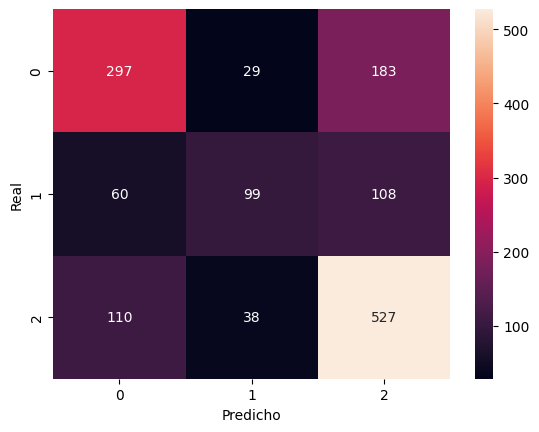

In [51]:
sns.heatmap(confusion_matrix(Y_test_malos, gs_xgb.best_estimator_.predict(X_test_malos)), annot= True, fmt = 'g')
plt.xlabel('Predicho')
plt.ylabel('Real');

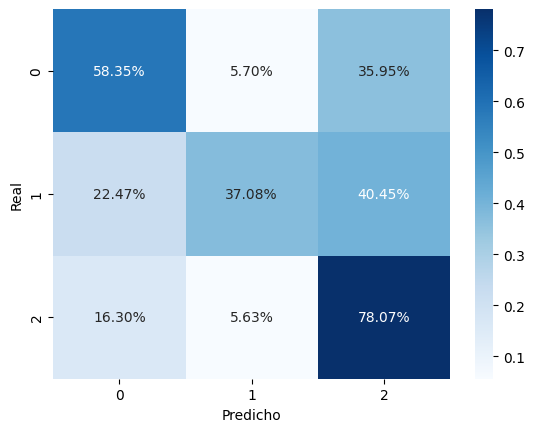

In [52]:
sns.heatmap(confusion_matrix(Y_test_malos, gs_xgb.best_estimator_.predict(X_test_malos), normalize='true'), annot=True, 
            fmt='.2%', cmap='Blues');
plt.xlabel('Predicho')
plt.ylabel('Real');

Después de muchas pruebas con diferentes pesos no hemos conseguido mejorar el accuracy de una manera perceptible. En ocasiones se podía conseguir un 0,0001 de mejora en test pero a costa de aumentar más el sobreajuste, por lo que no merece la pena usar un modelo con pesos alterados.

#### ADA BOOST

Los algoritmos de ADA boost asignan pesos a cada instancia y los ajustan en cada iteración, dando más importancia a los casos problemáticos, mejorando el rendimiento global del modelo. Para el modelo que clasifica los géneros peor clasificables vamos a intentar aplicar este tipo de algoritmo y ver si mejora en los errores. Es cierto que los algoritmos de ADA boost son más sensibles al ruido y valores atípicos, por lo que habrá que probarlo:

In [53]:
X_malos = generos_malos.drop(columns={'genero'})
Y_malos = generos_malos['genero']

X_train_malos, X_test_malos, Y_train_malos, Y_test_malos = train_test_split(X_malos, Y_malos, test_size=0.2, random_state=42)

In [56]:
clasi_base = DecisionTreeClassifier(max_depth=1)

ada = AdaBoostClassifier(clasi_base)

params = {'n_estimators' : [50,100,200],
          'learning_rate' : [0.01, 0.02, 0.1, 0.2, 0.5]}

gs_ada = GridSearchCV(estimator=ada, 
                             param_grid=params, 
                             cv=2, 
                             scoring='accuracy', 
                             verbose=1, 
                             n_jobs=4)

In [57]:
gs_ada.fit(X_train_malos, Y_train_malos)

Fitting 2 folds for each of 15 candidates, totalling 30 fits


GridSearchCV(cv=2,
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1)),
             n_jobs=4,
             param_grid={'learning_rate': [0.01, 0.02, 0.1, 0.2, 0.5],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=1)

In [58]:
print(gs_ada.best_params_)

{'learning_rate': 0.5, 'n_estimators': 100}


In [59]:
print('Accuracy en train: ', accuracy_score(Y_train_malos, gs_ada.best_estimator_.predict(X_train_malos)))
print('Accuracy en test: ', accuracy_score(Y_test_malos, gs_ada.best_estimator_.predict(X_test_malos)))

Accuracy en train:  0.624504566603481
Accuracy en test:  0.5920055134390075


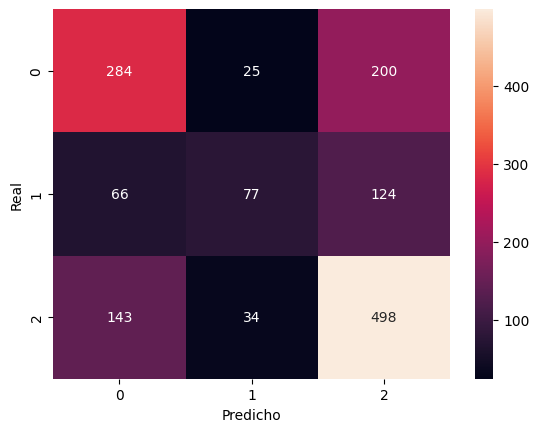

In [60]:
sns.heatmap(confusion_matrix(Y_test_malos, gs_ada.best_estimator_.predict(X_test_malos)), annot= True, fmt = 'g')
plt.xlabel('Predicho')
plt.ylabel('Real');

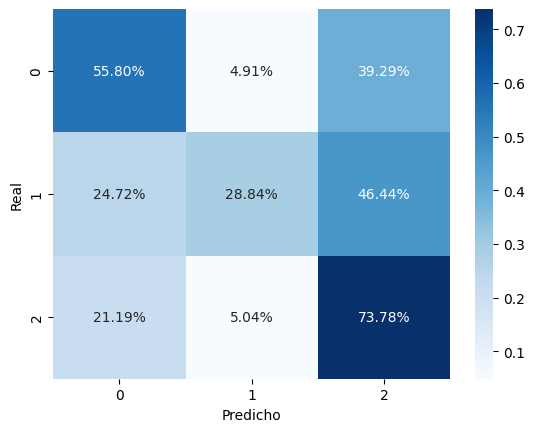

In [61]:
sns.heatmap(confusion_matrix(Y_test_malos, gs_ada.best_estimator_.predict(X_test_malos), normalize='true'), annot=True, 
            fmt='.2%', cmap='Blues');
plt.xlabel('Predicho')
plt.ylabel('Real');

El algoritmo ADA boost no consigue mejorar la métrica de accuracy en ningún caso comparado al XGBoost

----

#### ENSEMBLE

HARD VOTING

Vamos a intentar hacer un ensemble de diferentes modelos para ver si conseguimos mejorar las predicciones en los géneros mal predichos:

In [62]:
X_malos = generos_malos.drop(columns={'genero'})
Y_malos = generos_malos['genero']

X_train_malos, X_test_malos, Y_train_malos, Y_test_malos = train_test_split(X_malos, Y_malos, test_size=0.2, random_state=42)

In [63]:
bosque = RandomForestClassifier()

bosque_param = {
    "n_estimators": [10, 20, 30],
    'max_depth' : [2, 5, 7],
    'max_features' : ['log2']
}

gs_bosque = GridSearchCV(estimator=bosque,
                         param_grid=bosque_param,
                         cv = 2,
                         scoring = 'accuracy',
                         verbose = 1,
                         n_jobs = 4)

xgb = xgboost.XGBRFClassifier()

params = {'booster' : ['gbtree'],
          'eta' : [0.01, 0.05, 0.1, 0.2],
          'max_depth' : [2, 5, 7],
          'objective' : ['multi:softprob'],
          'num_class' : [3],
          'eval_metric' : ['mlogloss']}

gs_xgb = GridSearchCV(estimator=xgb,
                      param_grid=params,
                      cv=2,
                      scoring='accuracy',
                      verbose=1,
                      n_jobs=4)

Probando un ensemble de hard voting entre un grid search de random forest y otro grid search de xgboost:

In [64]:
estimators = [('rf', gs_bosque), ('xgb', gs_xgb)]

voting_clf = VotingClassifier(estimators=estimators, voting='hard')

In [65]:
voting_clf.fit(X_train_malos, Y_train_malos)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


Fitting 2 folds for each of 12 candidates, totalling 24 fits


VotingClassifier(estimators=[('rf',
                              GridSearchCV(cv=2,
                                           estimator=RandomForestClassifier(),
                                           n_jobs=4,
                                           param_grid={'max_depth': [2, 5, 7],
                                                       'max_features': ['log2'],
                                                       'n_estimators': [10, 20,
                                                                        30]},
                                           scoring='accuracy', verbose=1)),
                             ('xgb',
                              GridSearchCV(cv=2,
                                           estimator=XGBRFClassifier(base_score=None,
                                                                     booster=None,
                                                                     callbacks=None,
                                                                     colsample_bylevel=None,
                                                                     colsample_bytree=None...
                                                                     monotone_constraints=None,
                                                                     multi_strategy=None,
                                                                     n_estimators=None,
                                                                     n_jobs=None,
                                                                     num_parallel_tree=None,
                                                                     objective='binary:logistic',
                                                                     random_state=None,
                                                                     reg_alpha=None, ...),
                                           n_jobs=4,
                                           param_grid={'booster': ['gbtree'],
                                                       'eta': [0.01, 0.05, 0.1,
                                                               0.2],
                                                       'eval_metric': ['mlogloss'],
                                                       'max_depth': [2, 5, 7],
                                                       'num_class': [3],
                                                       'objective': ['multi:softprob']},
                                           scoring='accuracy', verbose=1))])

In [66]:
print('Accuracy en train: ', accuracy_score(Y_train_malos, voting_clf.predict(X_train_malos)))
print('Accuracy en test: ', accuracy_score(Y_test_malos, voting_clf.predict(X_test_malos)))

Accuracy en train:  0.7101499224539032
Accuracy en test:  0.6140592694693315


In [67]:
for clf in (gs_bosque, gs_xgb, voting_clf):
    clf.fit(X_train_malos, Y_train_malos)
    y_pred = clf.predict(X_test_malos)
    print(clf.__class__.__name__, accuracy_score(Y_test_malos, y_pred))

Fitting 2 folds for each of 9 candidates, totalling 18 fits


GridSearchCV 0.5995864920744314
Fitting 2 folds for each of 12 candidates, totalling 24 fits
GridSearchCV 0.6181943487250172
Fitting 2 folds for each of 9 candidates, totalling 18 fits
Fitting 2 folds for each of 12 candidates, totalling 24 fits
VotingClassifier 0.6188835286009648


Con hard voting no conseguimos mejorar el accuracy del que conseguíamos con nuestro mejor modelo, es decir, el xgboost por separado. Sin embargo, hay que tener en cuenta que este tipo de ensemble asume que cada modelo tiene aproximadamente el mismo peso en términos de predicción. Si un modelo tiende a ser significativamente mejor que los demás, podría tener más sentido darle más peso en el ensemble, lo cual se puede lograr con un ensemble de soft voting:

SOFT VOTING

In [68]:
X_malos = generos_malos.drop(columns={'genero'})
Y_malos = generos_malos['genero']

X_train_malos, X_test_malos, Y_train_malos, Y_test_malos = train_test_split(X_malos, Y_malos, test_size=0.2, random_state=42)

In [69]:
bosque = RandomForestClassifier()

bosque_param = {
    "n_estimators": [10, 20, 30],
    'max_depth' : [2, 5, 7],
    'max_features' : ['log2']
}

gs_bosque = GridSearchCV(estimator=bosque,
                         param_grid=bosque_param,
                         cv = 2,
                         scoring = 'accuracy',
                         verbose = 1,
                         n_jobs = 4)

xgb = xgboost.XGBRFClassifier()

params = {'booster' : ['gbtree'],
          'eta' : [0.01, 0.05, 0.1, 0.2],
          'max_depth' : [2, 5, 7],
          'objective' : ['multi:softprob'],
          'num_class' : [3],
          'eval_metric' : ['mlogloss']}

gs_xgb = GridSearchCV(estimator=xgb,
                      param_grid=params,
                      cv=2,
                      scoring='accuracy',
                      verbose=1,
                      n_jobs=4)

In [70]:
estimators = [('rf', gs_bosque), ('xgb', gs_xgb)]

voting_clf = VotingClassifier(estimators=estimators, voting='soft')

In [71]:
voting_clf.fit(X_train_malos, Y_train_malos)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


Fitting 2 folds for each of 12 candidates, totalling 24 fits


VotingClassifier(estimators=[('rf',
                              GridSearchCV(cv=2,
                                           estimator=RandomForestClassifier(),
                                           n_jobs=4,
                                           param_grid={'max_depth': [2, 5, 7],
                                                       'max_features': ['log2'],
                                                       'n_estimators': [10, 20,
                                                                        30]},
                                           scoring='accuracy', verbose=1)),
                             ('xgb',
                              GridSearchCV(cv=2,
                                           estimator=XGBRFClassifier(base_score=None,
                                                                     booster=None,
                                                                     callbacks=None,
                                                                     colsample_bylevel=None,
                                                                     colsample_bytree=None...
                                                                     monotone_constraints=None,
                                                                     multi_strategy=None,
                                                                     n_estimators=None,
                                                                     n_jobs=None,
                                                                     num_parallel_tree=None,
                                                                     objective='binary:logistic',
                                                                     random_state=None,
                                                                     reg_alpha=None, ...),
                                           n_jobs=4,
                                           param_grid={'booster': ['gbtree'],
                                                       'eta': [0.01, 0.05, 0.1,
                                                               0.2],
                                                       'eval_metric': ['mlogloss'],
                                                       'max_depth': [2, 5, 7],
                                                       'num_class': [3],
                                                       'objective': ['multi:softprob']},
                                           scoring='accuracy', verbose=1))],
                 voting='soft')

In [72]:
print('Accuracy en train: ', accuracy_score(Y_train_malos, voting_clf.predict(X_train_malos)))
print('Accuracy en test: ', accuracy_score(Y_test_malos, voting_clf.predict(X_test_malos)))

Accuracy en train:  0.7091159744959503
Accuracy en test:  0.6099241902136457


In [73]:
for clf in (gs_bosque, gs_xgb, voting_clf):
    clf.fit(X_train_malos, Y_train_malos)
    y_pred = clf.predict(X_test_malos)
    print(clf.__class__.__name__, accuracy_score(Y_test_malos, y_pred))

Fitting 2 folds for each of 9 candidates, totalling 18 fits
GridSearchCV 0.6050999310820124
Fitting 2 folds for each of 12 candidates, totalling 24 fits
GridSearchCV 0.6181943487250172
Fitting 2 folds for each of 9 candidates, totalling 18 fits
Fitting 2 folds for each of 12 candidates, totalling 24 fits
VotingClassifier 0.6030323914541695


Vemos que ningún tipo de ensemble consigue mejorar la métrica que el modelo de XGBoost por separado

----

#### CONCLUSIONES

Después de analizar las variables con las que contábamos en nuestro dataset hemos procedido a probar modelos para clasificar canciones por su género. Rápidamente hemos podido comprobar que esta tarea no iba a ser nada fácil, cosa que podíamos empezar a intuir desde el momento en el que hemos analizado nuestro dato por variables. El problema principal era que las distintas clases del target no tenían unas características que las diferenciaran de las demás claramente, por lo que los modelos tenían mucha dificultad a la hora de afirmar que una canción perteneciera a su género correcto. A medida que hemos incluido modelos más complejos hemos ido mejorando las métricas de precisión, sin embargo, percibíamos que algunas clases tendían a ser predichas más acertadamante que las demás. Concretamente, todos los modelos acertaban más con los géneros de rap, rock y EDM, mientras que tenían muchos más problemas con los géneros de pop, latin y R&B.

Visto esto, hemos decidido dividir el dataset en estos dos grupos y probar modelos, consiguiendo unos mejores resultados. En el caso de los géneros que se predecían bien, se ha conseguido acertar aún más. Por otro lado, en los géneros más difíciles, también hemos conseguido aumentar la métrica de acierto. En ambos casos, el tipo de algoritmo que mejores resultados ha dado entre los que hemos probado ha sido el de XGBoost, concretamente el XGBRFClassifier.

Ahora tendremos que ajustar los hiperparámetros para quedarnos con nuestros dos modelos finales que servirán para clasificar las canciones en estos dos grupos. Para que este proyecto pueda estar completo, primeramente tendremos que idear un modelo que distinga si la canción se trata de una de las "bien distinguibles" o una de las "mal distinguibles" para que después entre en su modelo correspondiente. Esto será lo que hagamos en el notebook de _modelos finales_